In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import date2num, num2date
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
mpl.style.use('seaborn')
import scipy.io as spio
import numpy as np
import pandas as pd
from cmocean import cm as cmo
import time
from datetime import datetime, timedelta
import copy

/Applications/anaconda/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import chi2

In [3]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.geodesic import Geodesic

## For geolocation via SOFAR channel acoustics we will use the time of the first energy peak, which corresponds to the minimum speed in the channel, at the axis.
### From: https://dosits.org/science/movement/sofar-channel/sound-travel-in-the-sofar-channel/
![SOFAR Channel](dosits_sofar.png "The SOFAR Channel")
##### From: http://noiselab.ucsd.edu/view/intro2hydro.pdf (Slide 28)
![H-phase_characteristic_waveform.png](H-phase_characteristic_waveform.png)

In [4]:
# Load data containing known submarine locations, CTBTO hydrophones,
#  and time of arrival for the first energy peak at each set of hydrophones.
ara_san_juan_data = np.load('ARA_San_Juan_data.npy').tolist()
ara_san_juan_data

{'arrival_time_sd': {'H04': [datetime.timedelta(0, 5, 184000)],
  'H10': [datetime.timedelta(0, 2, 86957),
   datetime.timedelta(0, 3, 130435),
   datetime.timedelta(0, 3, 130435)]},
 'arrival_times': {'H04S': [datetime.datetime(2017, 11, 15, 15, 19, 37, 363200)],
  'H10N': [datetime.datetime(2017, 11, 15, 14, 59, 14, 608696),
   datetime.datetime(2017, 11, 15, 15, 0, 42, 260870),
   datetime.datetime(2017, 11, 15, 15, 1, 36, 521739)],
  'H10S': [datetime.datetime(2017, 11, 15, 14, 58, 3, 513600),
   datetime.datetime(2017, 11, 15, 14, 59, 33, 715200),
   datetime.datetime(2017, 11, 15, 15, 0, 29, 702400)]},
 'ims_locs': {'H04S': (51.8, -46.883),
  'H10N': (-14.48, -7.845),
  'H10S': (-14.648, -8.941)},
 'sub_locs': {'iridium': {'coord': (-59.9, -46.1333),
   'radius_km': 10,
   'time': datetime.datetime(2017, 11, 15, 10, 30)},
  'self_reported': {'coord': (-60.1333, -46.7333),
   'time': datetime.datetime(2017, 11, 15, 3, 30)}}}

In [5]:
# Time of peak energy arrivals for each hydrophone triplet detecting the event.
#  These times were measured from the screen captures released by CTBTO below.
arrival_times = ara_san_juan_data['arrival_times']
arrival_times

{'H04S': [datetime.datetime(2017, 11, 15, 15, 19, 37, 363200)],
 'H10N': [datetime.datetime(2017, 11, 15, 14, 59, 14, 608696),
  datetime.datetime(2017, 11, 15, 15, 0, 42, 260870),
  datetime.datetime(2017, 11, 15, 15, 1, 36, 521739)],
 'H10S': [datetime.datetime(2017, 11, 15, 14, 58, 3, 513600),
  datetime.datetime(2017, 11, 15, 14, 59, 33, 715200),
  datetime.datetime(2017, 11, 15, 15, 0, 29, 702400)]}

In [6]:
arrival_time_sd = ara_san_juan_data['arrival_time_sd']
arrival_time_sd

{'H04': [datetime.timedelta(0, 5, 184000)],
 'H10': [datetime.timedelta(0, 2, 86957),
  datetime.timedelta(0, 3, 130435),
  datetime.timedelta(0, 3, 130435)]}

###  Note that in the images below, for Ascension Island, there are at least three distinct peaks. The first peak is the one we will analyze first. Later on, I will show that the second and thrid peaks are likely reflections off of the South American continental slope.
### For Crozet Islands (H04S), I disregard the faint energy spike at 0.04 hours. It might be that some energy transferred from the water to the mountainous seafloor where it travelled faster for a while before re-entering the SOFAR channel. We want to use the stronger energy peak at about 0.145 hours since it travelled at speeds for which we have less uncertainty in sound speed.
![high_energy_event_ctbto.JPG](high_energy_event_ctbto.JPG)

In [7]:
# Global ocean sound speed data source: World Ocean Atlas 2009
#  http://staff.washington.edu/dushaw/WOA/WOA09/allmats09.tgz
#  https://www.nodc.noaa.gov/OC5/WOA09/pr_woa09.html (for original high resolution data)
#  It contains sound speed profiles (SSP) at 1 degree latitude/longitude resolution.
#  Each SSP contains sound speed at the 33 standard depths from 0 to 5500 meters.
#  See http://staff.washington.edu/dushaw/WOA/ for further explanation of the data.
#  Sound speed wasn't measured directly, but was derived from temperature, salinity, and pressure using 
#  the Del Grosso sound speed equation (http://staff.washington.edu/dushaw/epubs/OnEquationsSSP.pdf)

# Load data containing historical average sound speed for the month of November
speed_raw = spio.loadmat(r'./allmats09/lev_nov.mat', squeeze_me=True)
coords_raw = spio.loadmat(r'./allmats09/lev_latlonZ.mat', squeeze_me=True)
grid = (180,360) # rows, columns (latitude, longitude)
grid3d = (180,360,33) # rows, columns, levels (latitude, longitude, depth)

# The .mat data is stored like this:
#  x[0] to x[359] is longitude from 0.5 degrees (just east of the prime meridian 
#   passing through Greenwich, England) traveling east all the way to -0.5 degrees
#  y[0] to y[179] is latitude from the south pole -89.5 degrees to the north pole 89.5 degrees

# Reshape into a 180 vertical by 360 horizontal cell grid and adjust to get sound speed 
speed_woa = np.matlib.reshape(speed_raw['c'],grid3d) / 100 + 1000
lats = np.matlib.reshape(coords_raw['lat'],grid) * 0.1
lons = np.matlib.reshape(coords_raw['lon'],grid) * 0.1
depths = coords_raw['z']
lat_axis = lats[:,0]
lon_axis = lons[0]

In [8]:
# There are 33 standard "Levitus" depths.
#  Levitus is for Sydney Levitus, the creator of the original world ocean atlas.
#  These depths are spaced closer together near the surface where sound speed is more dynamic.
print('The %s standard Levitus depths (meters):' % depths.size)
print(depths)

The 33 standard Levitus depths (meters):
[   0   10   20   30   50   75  100  125  150  200  250  300  400  500  600
  700  800  900 1000 1100 1200 1300 1400 1500 1750 2000 2500 3000 3500 4000
 4500 5000 5500]


In [9]:
# Find the depth and the speed of sound at the Deep Sound Channel Axis (DSCA)

# Note that, for computational reasons, all of the sound speed profiles in the data have 
#  been extended to 5500 meters even where the seafloor is shallower than that depth,
#  which could cause some problems finding the depth and speed of the DSCA.
# In reality, the DSCA (aka SOFAR channel axis) is never deeper than 
# about 2000 meters due to sea pressure overcoming the colder temperature.
# To reduce the possibility of bad data in DSCA speeds, we will only look down to 2000 meters.
# For my application this hack is likely sufficient, but to be more general, it might be better
#  to use actual bathymetric data to limit the depth, not just a simple 2000 meter cutoff.

# Find minimum sound speed between 0 and 2000 meters
dsca_speed = speed_woa[:,:,:-7].min(axis = 2)

# Find the depth of the deep sound channel axis
dsca_depth = depths[speed_woa[:,:,:-7].argmin(axis = 2)]

print('The median speed at the axis of the deep sound channel is %s m/s.' % int(np.median(dsca_speed)))
print('But watch out because this dataset has ocean sound speeds even where there is no ocean...')

The median speed at the axis of the deep sound channel is 1478 m/s.
But watch out because this dataset has ocean sound speeds even where there is no ocean...


In [10]:
# Simple example: The Argentine Basin is near Latitude: -47.5, Longitude: -52.5
# That corresponds to row, y = 42 and column, x = 307 in the speed matrix
# To convert latitude to y: np.clip(int(lat + 90), 0, 179)
# To convert longitude to x: np.clip(int(lon % 360), 0, 359), where % is the python modulo operator
print('SSP in the Argentine Basin (November)\n')
print('Depth (m)\tSpeed (m/s)')
for d, s in zip(depths, speed_woa[42,307]):
    print(d,'\t\t',s)

SSP in the Argentine Basin (November)

Depth (m)	Speed (m/s)
0 		 1482.38
10 		 1482.35
20 		 1482.16
30 		 1481.99
50 		 1481.29
75 		 1479.53
100 		 1477.15
125 		 1475.57
150 		 1473.89
200 		 1472.58
250 		 1472.23
300 		 1472.09
400 		 1470.75
500 		 1471.04
600 		 1471.52
700 		 1473.14
800 		 1473.83
900 		 1474.93
1000 		 1476.34
1100 		 1477.7
1200 		 1479.4
1300 		 1481.22
1400 		 1482.58
1500 		 1484.3
1750 		 1488.69
2000 		 1492.56
2500 		 1500.03
3000 		 1506.27
3500 		 1512.95
4000 		 1520.1
4500 		 1527.44
5000 		 1535.85
5500 		 1544.96


In [11]:
def coords_to_index(coords):
    '''Helper function to convert (longitude, latitude) pairs into an index 
    suitable for retrieving data from the (180, 360) array world ocean atlas 
    1 degree resolution dataset.
    
    coords must be lon, lat pairs in a format that can be turned into a numpy ndarray of index values
    
    returns a numpy ndarray of x values and another of y values'''
    
    coords = np.asanyarray(coords).T.copy()
    
    lon_as_x = np.clip(coords[0] % 360, 0, 359).astype(int)
    lat_as_y = np.clip(coords[1] + 90, 0, 179).astype(int)
    
    return lat_as_y, lon_as_x

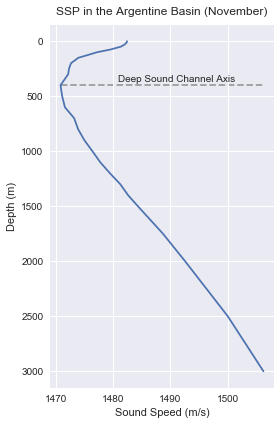

In [12]:
arg_basin = (-52.5, -47.5) # longitude, latitude coordinate
ssp_arg_basin = speed_woa[coords_to_index(arg_basin)][:-5] # We'll just show the upper 3000 meters
fig, ax = plt.subplots(figsize = (4,6))
ax.plot(ssp_arg_basin, depths[:-5], zorder = 2)
ax.invert_yaxis()
#ax.set_ylim(3000,0)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Sound Speed (m/s)')
ax.set_title('SSP in the Argentine Basin (November)',
             y = 1.01)
dsca_s_arg_basin = ssp_arg_basin[:-7].min()
dsca_d_arg_basin = depths[np.argmin(ssp_arg_basin[:-7])]
ax.plot([dsca_s_arg_basin, ssp_arg_basin.max()],
        [dsca_d_arg_basin, dsca_d_arg_basin], '--', zorder = 0, 
        alpha = 0.75, color = 'grey')
ax.text(dsca_s_arg_basin + 10, dsca_d_arg_basin - 30, 'Deep Sound Channel Axis')
fig.tight_layout()
plt.show()

In [13]:
# Load landmask and border shapefiles for plotting later
landmask_hi = r'./gshhg-shp-2.2.2/GSHHS_shp/l/GSHHS_l_L1.shp'
borders_hi = r'./gshhg-shp-2.2.2/WDBII_shp/l/WDBII_border_l_L1.shp'
landmask_lo = r'./gshhg-shp-2.2.2/GSHHS_shp/c/GSHHS_c_L1.shp'
borders_lo = r'./gshhg-shp-2.2.2/WDBII_shp/c/WDBII_border_c_L1.shp'
land_feature_hi = ShapelyFeature(Reader(landmask_hi).geometries(),
                                 ccrs.PlateCarree())
border_feature_hi = ShapelyFeature(Reader(borders_hi).geometries(),
                                   ccrs.PlateCarree(), edgecolor = 'black')
land_feature_lo = ShapelyFeature(Reader(landmask_lo).geometries(),
                                 ccrs.PlateCarree())
border_feature_lo = ShapelyFeature(Reader(borders_lo).geometries(),
                                   ccrs.PlateCarree(), edgecolor = 'black')


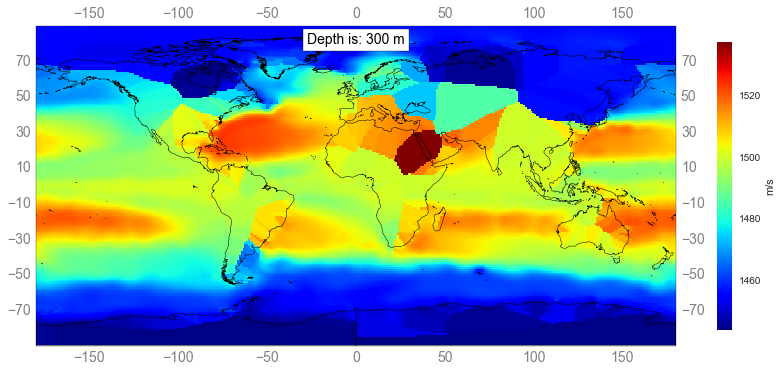

In [14]:
# Let's error check our work so far by reproducing the image found
#  at the bottom of this page: http://staff.washington.edu/dushaw/WOA/
#  If the coldest water isn't at the poles, then we've really done something wrong.
#  We are using sound speed data is for November, not the annual average, so it won't look exactly the same.
#  And our plot will have the prime meridian (0 degrees longitude) at the center instead.

level = 11 # level 11 corresponds to a depth of 300 meters

# if you don't "add a cyclic point," it makes a white line at the prime meridian...
spd_cyc, lon_cyc = add_cyclic_point(speed_woa[:,:,level], coord=lon_axis)

# Plate Carrée projection turns the surface of the earth into a flat 
#  2d surface with equal sized lat/lon grid rectangles (aka equirectangular projection)
projection=ccrs.PlateCarree()

fig = plt.figure(figsize = (12,5))
ax = plt.subplot(111,projection = projection)
# turn the sound speeds at 300 meters into a pseudocolor mesh plot
cm = ax.pcolormesh(lon_cyc, lat_axis, spd_cyc,
                   transform=projection,
                   cmap='jet')
# Add coastlines
ax.add_feature(land_feature_lo, facecolor='None', edgecolor='black',
               linewidth = 0.5); 
ax.set_global()
#ax.set_extent([-70,-50,-40,-50])

gl = ax.gridlines(draw_labels=True,
                  ylocs = np.arange(-90,90,20),
                  xlocs = np.arange(-150,151,50),
                  color = 'black', linewidth = 0.5,
                  linestyle='--', alpha = 0)
gl.xlabel_style = {'size': 14, 'color': 'gray'}
gl.ylabel_style = {'size': 14, 'color': 'gray'}
cbar = fig.colorbar(cm, ax=ax, shrink=0.9) 
cbar.set_label('m/s')
ax.text(0, 80, 'Depth is: %s m' % depths[level], color='black', 
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize = 14, horizontalalignment = 'center')
fig.tight_layout(pad = 2)
plt.show()

In [15]:
# Source of triplet hydrophone location data:
#  Ascension: https://www.ctbto.org/fileadmin/user_upload/pdf/Spectrum/2014/Spectrum22_p18.pdf
#  Crozet: https://ctnw.ctbto.org/DMZ/event/3239/posters/B6FEA22F10044A6E9C8168B41723F7D0

ims = ara_san_juan_data['ims_locs']
ims

{'H04S': (51.8, -46.883), 'H10N': (-14.48, -7.845), 'H10S': (-14.648, -8.941)}

# ARA San Juan positional data from Armada Argentina
##### https://upload.wikimedia.org/wikipedia/commons/b/ba/Cable_ARA_San_Juan_SUBMISS.jpg
##### All times assumed to be Argentina Time (ART), -0300 UTC/GMT
![Cable_ARA_San_Juan_SUBMISS.jpg](Cable_ARA_San_Juan_SUBMISS.jpg)

In [16]:
# Submarine position data
#  Coordinates are (longitude, latitude) 
self_reported = ara_san_juan_data['sub_locs']['self_reported']
iridium = ara_san_juan_data['sub_locs']['iridium']
print('Last position reported from ARA San Juan, assumed to be from onboard GPS:')
print(self_reported) # Remember, I've defined coords to be (longitude, latitude)

Last position reported from ARA San Juan, assumed to be from onboard GPS:
{'coord': (-60.1333, -46.7333), 'time': datetime.datetime(2017, 11, 15, 3, 30)}


In [17]:
# Last communication received is assumed to be via Iridium satellite phone.
# I assume that the company calulculated a circular area of uncertainty and gave it to the Navy.
# Iridium radius was measured from a screen capture but I might not have that correct.
# Not sure if it is a 95% probability of containment circle, 50% CEP, or what.
# Either way, this information is just used for plotting, not for calculating time or
#  location of the CTBTO event.
print(iridium)

{'coord': (-59.9, -46.1333), 'radius_km': 10, 'time': datetime.datetime(2017, 11, 15, 10, 30)}


In [18]:
ascension_n = ims['H10N']
ascension_s = ims['H10S']
crozet_s = ims['H04S']

In [19]:
# Instantiate a WGS84 ellipsoid on which to calculate geodesic paths
geodesic = Geodesic()

In [20]:
def geodesic_data(start = None, end = None, brg = None, dist = None, num = 20, sample_dist = None):
    '''start and end: Optional (lon, lat) coordinate tuples (or iterables)
    brg: An optional path bearing (degrees). Ignored if both start and end are supplied.
        If only start (end) is supplied, brg is the initial (final) bearing.
    dist: Path distance in meters. Ignored if start and end are supplied.
    num: The number of sample points to return along the path.
    
    Returns: dictionary with start, end, dist, dist_arr, brg_initial, brg_final, and coords.
        Coords is a numpy ndarray of lons and lats of shape (num, 2)'''
    
    if not start is None and not end is None:
        start = np.asanyarray(start)
        end = np.asanyarray(end)
        dist, brg_initial, brg_final = np.hsplit(geodesic.inverse(start, end)[0],3)
        if not sample_dist is None:
            num = int(dist / sample_dist)
        distances = np.linspace(0, dist, num)
        coords, fwd_brgs = np.hsplit(geodesic.direct(start, brg_initial, distances),[2])
        
    elif not start is None and not brg is None and not dist is None:
        start = np.asanyarray(start)
        brg_initial = np.asanyarray(brg)
        dist = np.asanyarray(dist)
        if not sample_dist is None:
            num = int(dist / sample_dist)
        distances = np.linspace(0, dist, num)
        coords, fwd_brgs = np.hsplit(geodesic.direct(start, brg_initial, distances),[2])
        end = coords[-1]
        brg_final = fwd_brgs[-1]
        
    elif not end is None and not brg is None and not dist is None:
        brg_final = np.asanyarray(brg)
        end = np.asanyarray(end)
        dist = np.asanyarray(dist)
        if not sample_dist is None:
            num = int(dist / sample_dist)
        distances = np.linspace(dist, 0, num)
        coords, start_brgs = np.hsplit(geodesic.direct(end, (180 + brg_final) % 360,
                                                           distances),[2])
        start = coords[0]
        brg_initial = (start_brgs[0] + 180) % 360
        
    d = {'start':start, 'end':end, 'dist':dist, 'dist_arr':distances,
         'brg_initial':brg_initial, 'brg_final':brg_final, 'coords': coords}
    
    return d

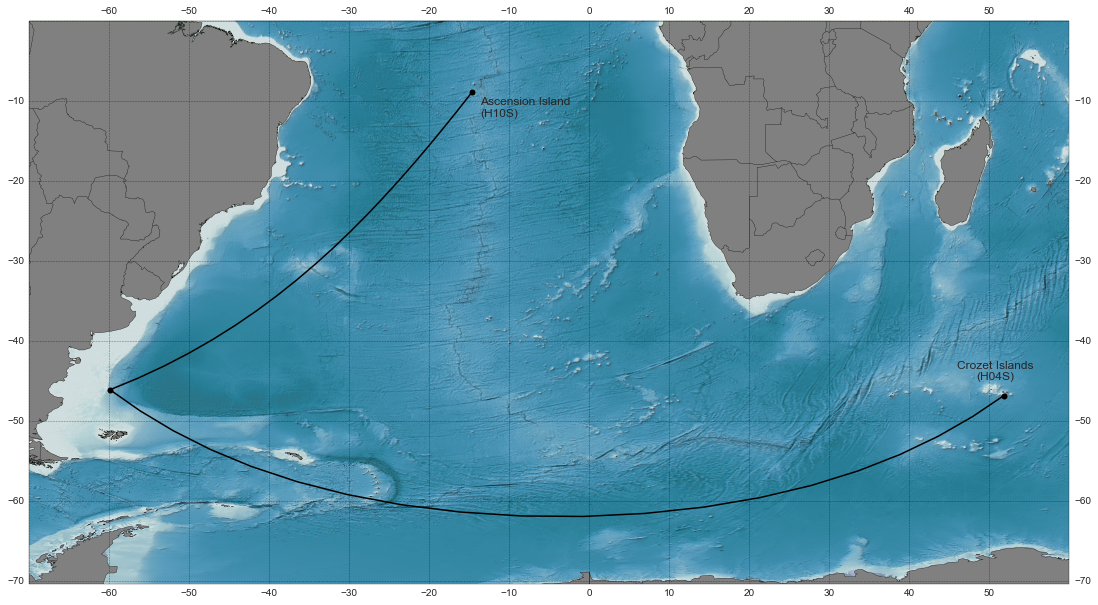

In [21]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111,projection = projection)
extent = [-70,60,-50,0]
ax.set_extent(extent)
ax.add_wms('https://gis.ngdc.noaa.gov/arcgis/services/web_mercator/gebco_2014_hillshade/MapServer/WMSServer?',
           '0')

gl = ax.gridlines(draw_labels=True,
                  ylocs = np.arange(-90,90,10),
                  xlocs = np.arange(-180,180,10),
                  color = 'black', linewidth = 0.5,
                  linestyle='--', alpha = 0.5)

ax.add_feature(land_feature_hi, facecolor='grey', edgecolor='black');
ax.add_feature(border_feature_hi, edgecolor='black', facecolor = 'grey');

lkp_to_asc = geodesic_data(start = iridium['coord'],
                           end = ascension_s)['coords']
lkp_to_cro = geodesic_data(start = iridium['coord'],
                           end = crozet_s)['coords']

plt.plot(lkp_to_asc[:,0],lkp_to_asc[:,1], color = 'black',
         linewidth = 1.5, transform = ccrs.Geodetic())
plt.plot(ascension_s[0],ascension_s[1], color = 'black',
         marker = 'o', markersize = 6)
plt.plot(iridium['coord'][0],iridium['coord'][1], color = 'black',
         marker = 'o', markersize = 6)
plt.text(ascension_s[0] + 1, ascension_s[1] - 3, 'Ascension Island\n(H10S)',
         horizontalalignment='left', fontsize = 12,
         transform = ccrs.Geodetic())
plt.plot(lkp_to_cro[:,0],lkp_to_cro[:,1], color = 'black',
         linewidth = 1.5, transform = ccrs.Geodetic())
plt.plot(crozet_s[0],crozet_s[1], color = 'black',
         marker = 'o', markersize = 6)
plt.text(crozet_s[0] - 1, crozet_s[1] + 2, 'Crozet Islands\n(H04S)',
         horizontalalignment='center', fontsize = 12,
         transform = ccrs.Geodetic())
fig.tight_layout(pad = 2)

In [22]:
# The U.S. National Ice Center Daily Ice Edge product for 15 Nov 2017 depicts the daily sea ice pack 
#  (80% or greater sea ice), and the Marginal Ice Zone (MIZ). The marginal 
#  ice zone is the transition between the open ocean (ice free) and pack ice.
ice_edge = r'./nic_miz2017319sc_pl_a/nic_miz2017319sc_pl_a.shp'
ice_feature = ShapelyFeature(Reader(ice_edge).geometries(),
                             ccrs.PlateCarree(), edgecolor = 'black')

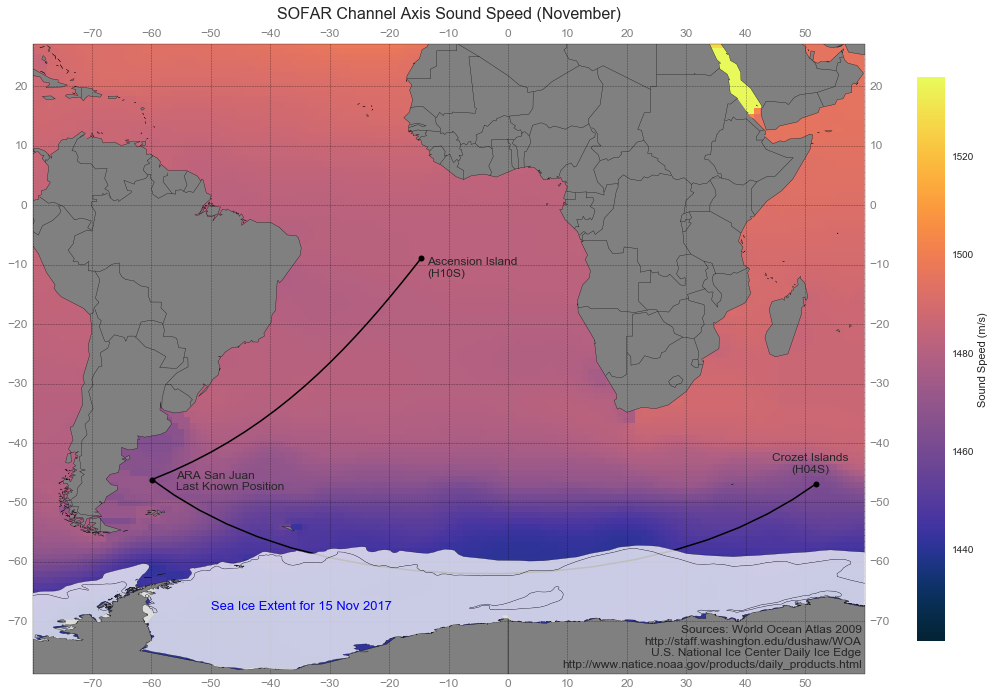

In [23]:
spd_cyc, lon_cyc = add_cyclic_point(dsca_speed, coord=lon_axis)
#dscaDep_cyc, lon_cyc = add_cyclic_point(dscaDepth, coord=lonAxis)
projection=ccrs.PlateCarree()
fig = plt.figure(figsize = (15,11))
ax = plt.subplot(111,projection = projection)
cm = ax.pcolormesh(lon_cyc, lat_axis, spd_cyc,
                   transform=ccrs.PlateCarree(),
                   cmap=cmo.thermal)

ax.add_feature(land_feature_lo, facecolor='grey', edgecolor='black');
ax.add_feature(border_feature_lo, edgecolor='black', facecolor = 'grey');

extent = [-80,60,-60,10]
ax.set_extent(extent)
#ax.set_global()
gl = ax.gridlines(draw_labels=True,
                  ylocs = np.arange(-90,90,10),
                  xlocs = np.arange(-180,180,10),
                  color = 'black', linewidth = 0.5,
                  linestyle='--', alpha = 0.5)
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}
cbar = fig.colorbar(cm, ax=ax, shrink=0.75)#, 
cbar.set_label('Sound Speed (m/s)')
plt.title('SOFAR Channel Axis Sound Speed (November)', y = 1.03,
          fontsize = 16)

last_pos = iridium['coord']

plt.plot(lkp_to_asc[:,0],lkp_to_asc[:,1], color = 'black',
         linewidth = 1.5, transform = ccrs.Geodetic())
plt.plot(ascension_s[0],ascension_s[1], color = 'black',
         marker = 'o', markersize = 6)
plt.plot(iridium['coord'][0],iridium['coord'][1], color = 'black',
         marker = 'o', markersize = 6)
plt.text(ascension_s[0] + 1, ascension_s[1] - 3, 'Ascension Island\n(H10S)',
         horizontalalignment='left', fontsize = 12,
         transform = ccrs.Geodetic())
plt.plot(lkp_to_cro[:,0],lkp_to_cro[:,1], color = 'black',
         linewidth = 1.5, transform = ccrs.Geodetic())
plt.plot(crozet_s[0],crozet_s[1], color = 'black',
         marker = 'o', markersize = 6)
plt.text(crozet_s[0] - 1, crozet_s[1] + 2, 'Crozet Islands\n(H04S)',
         horizontalalignment='center', fontsize = 12,
         transform = ccrs.Geodetic())
plt.text(last_pos[0] + 4, last_pos[1] - 1.7, 'ARA San Juan\nLast Known Position',
         horizontalalignment='left', fontsize = 12,
         transform = ccrs.Geodetic());

ax.add_feature(ice_feature,facecolor = 'white', alpha = 0.75, zorder = 10)

plt.text(-50,-68, 'Sea Ice Extent for 15 Nov 2017',
         horizontalalignment='left', fontsize = 13, zorder = 11, color = 'blue')
plt.text(59.5,-77.75, 'Sources: World Ocean Atlas 2009\nhttp://staff.washington.edu/dushaw/WOA' +
         '\nU.S. National Ice Center Daily Ice Edge' + 
         '\nhttp://www.natice.noaa.gov/products/daily_products.html',
         fontsize = 12, horizontalalignment='right');
fig.facecolor = 'white'
fig.tight_layout(pad = 2)
#plt.savefig('SOFAR_channel_axis_sound_speed_NOV.png')

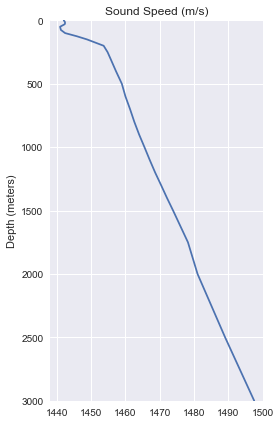

In [24]:
ssp_under_ice = speed_woa[coords_to_index((12,-60))]
fig, ax = plt.subplots(figsize = (4,6))
ax.plot(ssp_under_ice[:-5], depths[:-5])
ax.invert_yaxis()
ax.set_ylim(3000,0)
ax.set_ylabel('Depth (meters)')
ax.set_title('Sound Speed (m/s)')
fig.facecolor = 'white'
fig.tight_layout()
#plt.savefig('SSP_under_ice.png')
plt.show()

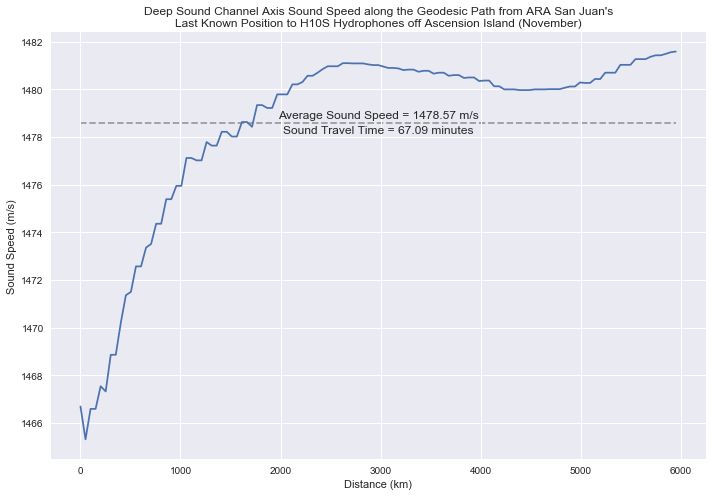

In [25]:
# Let's see how the sound speed changes along the SOFAR channel axis
# from the last known position to the H10S hydrophone triplet off Ascension Island

path_data = geodesic_data(iridium['coord'],ascension_s,sample_dist = 50000)
coords = path_data['coords']
dist_arr = path_data['dist_arr']
dist = path_data['dist'][0]
speed_asc = dsca_speed[coords_to_index(coords)]
mean_speed = speed_asc.mean()

# Plot sound speed vs. distance
fig, ax = plt.subplots(figsize = (10,7))
ax.plot([0, dist/1000], [mean_speed, mean_speed], '--', zorder = 0,
        alpha = 0.75, color = 'grey')
travel_time = np.round(dist / mean_speed / 60,2)
plt_text = (('Average Sound Speed = %s m/s\n' % np.round(mean_speed,2)),
            ('Sound Travel Time = %s minutes' % travel_time))
plt.text(dist/2000, mean_speed + 0.1, plt_text[0],
         fontsize = 12, horizontalalignment='center', verticalalignment = 'center')
plt.text(dist/2000, mean_speed - 0.3, plt_text[1],
         fontsize = 12, horizontalalignment='center', verticalalignment = 'center')
plt.plot(dist_arr/1000, speed_asc)
ax.set_ylabel('Sound Speed (m/s)')
ax.set_xlabel('Distance (km)')
title = ('Deep Sound Channel Axis Sound Speed along the Geodesic Path from ARA San Juan\'s\n' +
         'Last Known Position to H10S Hydrophones off Ascension Island (November)')
ax.set_title(title)
fig.facecolor = 'white'
fig.tight_layout()
#plt.savefig('Spd_to_ascension.png')
plt.show();

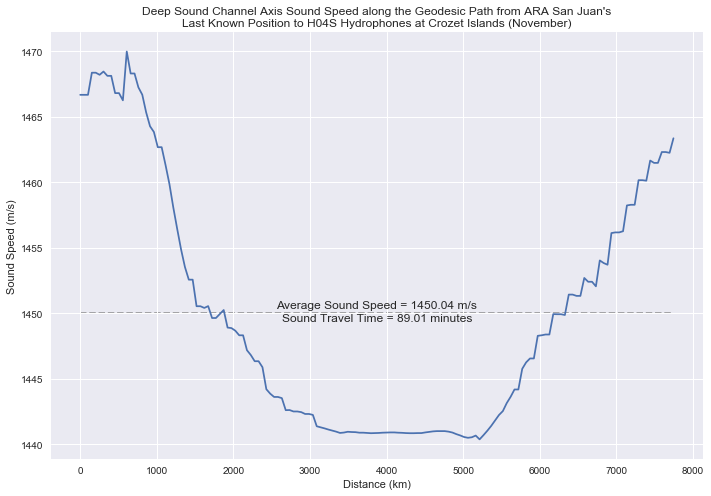

In [26]:
# Now let's compare that to the SOFAR channel axis sound speed
# from the last known position to the H04S hydrophone triplet off the Crozet Islands

# Sample sound speed data every 50 km along the geodesic path, and find average speed
path_data = geodesic_data(iridium['coord'],crozet_s,sample_dist = 50000)
coords = path_data['coords']
dist_arr = path_data['dist_arr']
dist = path_data['dist'][0]
speed_cro = dsca_speed[coords_to_index(coords)]
mean_speed = speed_cro.mean()

# Plot sound speed vs. distance
fig, ax = plt.subplots(figsize = (10,7))
ax.plot([0, dist/1000], [mean_speed, mean_speed], '--', zorder = 0,
        alpha = 0.75, color = 'grey')
travel_time = np.round(dist/mean_speed/60,2)
plt_text = (('Average Sound Speed = %s m/s\n' % np.round(mean_speed,2)),
            ('Sound Travel Time = %s minutes' % travel_time))
plt.text(dist/2000, mean_speed + 0.1, plt_text[0],
         fontsize = 12, horizontalalignment='center', verticalalignment = 'center')
plt.text(dist/2000, mean_speed - 0.4, plt_text[1],
         fontsize = 12, horizontalalignment='center', verticalalignment = 'center')
plt.plot(dist_arr/1000, speed_cro)
ax.set_ylabel('Sound Speed (m/s)')
ax.set_xlabel('Distance (km)')
title = ('Deep Sound Channel Axis Sound Speed along the Geodesic Path from ARA San Juan\'s\n' +
         'Last Known Position to H04S Hydrophones at Crozet Islands (November)')
ax.set_title(title)
fig.facecolor = 'white'
fig.tight_layout()
#plt.savefig('Spd_to_crozet.png')
plt.show();

In [27]:
def error_ellipse(m, weights = None, mass_level = 0.95):
    '''m is an 2 * n, or 3 * n dimensional array of lons and lats
    weights: optional array of weights (1 * n dimensional)
    mass_level: ellipse should contain this percentage of the distribution
    
    Returns: a dictionary of ellipse information'''
    
    #Adapted from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
    #and https://casper.berkeley.edu/astrobaki/index.php/Plotting_Ellipses_in_Python
    
    covariance = np.cov(m, aweights = weights)
    el_mean = np.average(m, axis = 1, weights = weights)
    
    # Find sigma value that equates to given mass_level on the chi squared distribution
    distances = np.linspace(0,20,20000)
    chi2_cdf = chi2.cdf(distances,df=2)
    multiplier = np.sqrt(distances[np.where(np.abs(chi2_cdf - mass_level) \
                                            == np.abs(chi2_cdf - mass_level).min())[0][0]])
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    # first principal axis is the new x-axis, so angle is degrees CCW from x-axis
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    semi_maj, semi_min = multiplier * np.sqrt(s)
    
    # strike angle is degrees clockwise from the y-axis
    strike = (90-angle) % 360
    ellipse_data = {'mean':el_mean, 'semi_major':semi_maj, 'semi_minor':semi_min, 
                    'semi_major_km':semi_maj * 111.12, 'semi_minor_km':semi_min * 111.12,
                    'strike':strike, 'ccw_from_x-axis': angle, 'mass_level':mass_level}
    
    return ellipse_data

In [28]:
def source_grid_to_ellipse(data_extent, mean, std, std_cutoff = 6, mass_level = 0.95):
    '''mean: a 3-dimensional array of mean source times (n-samples, x, y)
    std: a 3-dimensional array of std. dev. of sourcet times (n-samples, x, y)
    std_cutoff: Limit of acceptable std. dev. of source times for each cell. Above this 
        threshold, the error is too large to be considered a match/possible source location.
        Setting this too low could unnecesarily throw out valid source locations, but setting
        it too high might impact performance if the number of samples is high.
    mass_level: ellipse should contain this percentage of the distribution
    
    Returns a dictionary of error ellipse information.'''
    
    grid_shape = mean.shape
    data_extent = (min(data_extent[:2]),max(data_extent[:2]),
                   min(data_extent[2:]),max(data_extent[2:]))
    x = np.linspace(data_extent[0],data_extent[1],mean.shape[2])
    y = np.linspace(data_extent[2],data_extent[3],mean.shape[1])
    xx, yy = np.meshgrid(x,y)
    xx_mask = np.tile(xx,(mean.shape[0],1,1))
    yy_mask = np.tile(yy,(mean.shape[0],1,1))
    mask = std <= std_cutoff
    xx_mask = xx_mask[mask]
    yy_mask = yy_mask[mask]
    weights = (1/std**2)[mask]
    m = np.vstack((xx_mask,yy_mask))
    el_data = error_ellipse(m, weights = weights,
                            mass_level = mass_level)
    el_data['valid_samples'] = xx_mask.size
    el_data['avg_time'] = num2date(np.average(mean[mask], weights = weights))
    return el_data

In [29]:
# Let's analyze the first peak energy arrival at each hydrophone triplet.
sensor_info = {}
for station, sensors in zip(['H04', 'H10'], [['S'],['N','S']]):
    sensor_info[station] = {
        'time_sd': arrival_time_sd[station][0]}
    for sensor in sensors:
        s = station + sensor
        sensor_info[station][sensor] = {'coord': ims[s], 'time': arrival_times[s][0]}

sensor_info

{'H04': {'S': {'coord': (51.8, -46.883),
   'time': datetime.datetime(2017, 11, 15, 15, 19, 37, 363200)},
  'time_sd': datetime.timedelta(0, 5, 184000)},
 'H10': {'N': {'coord': (-14.48, -7.845),
   'time': datetime.datetime(2017, 11, 15, 14, 59, 14, 608696)},
  'S': {'coord': (-14.648, -8.941),
   'time': datetime.datetime(2017, 11, 15, 14, 58, 3, 513600)},
  'time_sd': datetime.timedelta(0, 2, 86957)}}

In [30]:
# This is the function that will be used to determine a source location and source time

def find_source(sensor_info, extent, grid_shape, dsca_speed, t_model = None,
                d_model = None, s_model = None, n_samples = None, rtn_priors = False):
    '''sensor_info expects a dictionary containing station codes as keys. For each station, there should
    be one or more hydrophone triplets (N,S,E,W). For each triplet, there should be keys of 'coord' 
    with (lon, lat) values, 'time' with sensor peak arrival time (datetime.datetime format), and 
    time_sd (in datetime.timedelta format).
    
    extent [lon_min, lon_max, lat_min, lat_max] defines the boundaries within which a source is to be
    found for the given hydroacoustive event.
    
    grid_shape (number of rows, number of columns) sets the resolution of the grid spacing.
    
    dsca_speed can be a scalar value, if a constant sound speed is assumed, or a global 2d array 
    of sound speeds with the origin at a coordinate of (0, -90) and the upper right at (180, 90).
    
    t_model, d_model, and s_model can be used to provide statistical models for uncertainty in 
    time of arrival, acoustic path distance, and sound speed, respectively. t_model will obtain it's
    standard deviation from the sensor_info dictionary record for each hydroacoustic station.
    
    n_samples (integer) sets the number of samples to draw from the uncertainty models.
    
    rtn_priors: if True, function will return the prior distributions for inspection. 
    (Default is False.)
    
    Returns a tuple containing grids (2d arrays) of mean source time (matplotlib float date format), 
    standard deviation of source time (in seconds), and optional priors. Source time is the average
    source time from that cell for the source to arrive at each hydrophone at the time observed. 
    Standard deviation is in seconds and is determined from the difference between the calculated
    source times for each of the n_samples.'''
    
    if len(sensor_info.items()) < 2:
        print('At least two sensors are required to find a source location.')
        return (None, None)
    
    # Instantiate the geodesic object on which to compute distances (defaults to WGS 1984 ellipsoid)
    geodesic = Geodesic()
    
    extent = (min(extent[:2]), max(extent[:2]),
              min(extent[2:]), max(extent[2:]))
    
    x = np.linspace(extent[0], extent[1], grid_shape[1])
    y = np.linspace(extent[2], extent[3], grid_shape[0])
    
    grid_size = grid_shape[0] * grid_shape[1]
    
    xx, yy = np.meshgrid(x, y)
    grid_coords = np.vstack((xx.ravel(), yy.ravel())).T
    
    if (not n_samples or
        n_samples < 1 or
        (t_model == d_model == s_model == None)):
        n_samples = 1
        
    # random variable shape
    rvs_shape = (n_samples, grid_shape[0], grid_shape[1])
    
    source_times = []
    
    '''# To keep the array operations in the RAM, and keep performance adequate,
    #  break the samples into chunks that keep array size < 50,000,000.
    if chunk_size is None:
        chunk_size = grid_size * n_samples
    if grid_size * n_samples > chunk_size:
        chunks = np.ceil(grid_size * n_samples / chunk_size)
    else:
        chunks = 1'''
    
    # we will capture the prior distributions so they can be viewed after processing
    priors = {'ea':[], 'ed':[], 'es':[]}
    
    # For each hydroacoustic station:
    for station, station_info in sensor_info.items():
        station_info = station_info.copy()
        if 'time_sd' in station_info:
            arrival_time_sd = (station_info.pop('time_sd')).total_seconds()
        else:
            arrival_time_sd = None
        #  Draw (n_samples * n_grid_cells) samples from each statistical distribution model (assumes
        #   that the uncertainties are the same for each hydrophone triplet at a station).
        if t_model:
            t_model.kwds['scale'] = arrival_time_sd
            ea = t_model.rvs(size = rvs_shape)
        else:
            ea = np.zeros(rvs_shape)
        if d_model:
            ed = d_model.rvs(size = rvs_shape)
        else:
            ed = np.zeros(rvs_shape)
        if s_model:
            es = s_model.rvs(size = rvs_shape)
        else:
            es = np.zeros(rvs_shape)

        # For each hydrophone triplet: 
        for hyd, hyd_info in station_info.items():
            h_coord = np.array(hyd_info['coord'])
            # convert the arrival time to a float value:
            #  date2num converts datetime object to number of days since 0001-01-01 UTC, plus 1
            #  lastly, convert to seconds to do all math is seconds
            t_arrival = np.array(date2num(hyd_info['time'])) * 24 * 3600

            # Calculate distances and bearings to each grid cell at once (vectorized)
            dist, brg = np.hsplit(geodesic.inverse(h_coord,grid_coords)[:,:2],2)
            # Sample sound speed at least every 50 km along each geodesic path
            #  spacing is the number of samples that will be made along each path
            spacing = (dist / 50000).max().astype(int)
            # dist_arr is the result of an n-dimensional version of np.linspace function
            dist_arr = dist/(spacing - 1) * np.arange(spacing)
            # add the starting bearing to the end of the distance array for faster processing
            dist_arr_brg = np.hstack((dist_arr,brg))

            if isinstance(dsca_speed, np.ndarray):
                # If dsca_speed is an ndarray, not a scalar value, then we need to find the average speed
                # Calculate mean sound speed for the entire grid, cell by cell, (this is the slow part, 
                #  not entirely vectorized)
                speed = []
                speed_std_factor = []
                # For each cell in the 2d grid (which has already been unravelled):
                for row in dist_arr_brg:
                    # Determine the coordinates at least every 50 km along the geodesic path
                    #  to the hydrophones (vectorized)
                    coords = geodesic.direct(h_coord, row[-1], row[:-1])[:,:2]
                    # Get sound speed at each coordinate and then
                    #  find the mean sound speed along the geodesic path (vectorized)
                    speeds = dsca_speed[coords_to_index(coords)]
                    speed.append(speeds.mean())
                    speed_std_factor.append(speeds.std() / 0.3)

                # Reshape speed array back into a 2d grid
                speed = np.array(speed).reshape(grid_shape)
                speed_std_factor = np.array(speed_std_factor)
                

            else:
                speed = dsca_speed
                speed_std_factor = 1
                
            # multiply ed by speed_std as a guesstimate of extra distance due to horizontal
            #  path deflection, then add one since it will be multiplied by geodesic distance
            if isinstance(speed_std_factor, np.ndarray):
                speed_std_factor = speed_std_factor.reshape((1,grid_shape[0],
                                                             grid_shape[1]))
                
            ed_adj = (ed * speed_std_factor) + 1
            
            if rtn_priors:
                for prior_type, prior_dist in zip(['ea','ed','es'],
                                                  [ea, ed_adj, es]):
                    priors[prior_type].append(prior_dist)
                                                        

            # Reshape dist array back into a 2d grid
            dist = dist.reshape(grid_shape)

            # Determine the source time for each of the n_samples (vectorized)
            #  Source Time = sensor arrival time - distance traveled / speed
            #  Each variable has uncertainty, e, that must be included 
            #   Distance error is a percentage (positive only). 
            #   Arrival time error and speed error are absolute values (can be pos or neg).
            #
            #  Dimensions: t_arrival (scalar), dist (len(y), len(x)), speed (len(y), len(x))
            #              ea, ed, and es have dimensions of (n_samples, len(y), len(x))
            #  Numpy's broadcasting rules cause t_source to have dimensions of 
            #   (n_samples, len(y), len(x))
            #  time is in seconds, dist is in meters, speed is in m/s
            
            '''for ea_chunk, ed_chunk, es_chunk in zip(np.array_split(ea, chunks, axis = 0),
                                                    np.array_split(ed_adj, chunks, axis = 0),
                                                    np.array_split(es, chunks, axis = 0)):'''

            t_source = t_arrival + ea - (dist * ed_adj/(speed + es))
            source_times.append(t_source)
            
    source_times = np.array(source_times)
    
    # return the mean arrival time and standard deviation at each cell in the grid
    if rtn_priors:
        return (source_times.mean(axis = 0) / 3600 / 24,
                source_times.std(axis = 0), 
                priors)
    else:
        return (source_times.mean(axis = 0) / 3600 / 24,
                source_times.std(axis = 0))

In [31]:
def plot_grid(data, data_extent, ax_extent, fig, projection,
              vmin = None, vmax = None, label = None,
              grid_lines = None):
    # Helper function that turns gridded std. dev. of source times into 
    #  matplotlib figure axis along with a colorbar
    
    if not data is None:
        data_supplied = True
    else:
        data_supplied = False
        
    ax = plt.subplot(111,projection = projection)
    
    if data_supplied:    
        x = np.linspace(data_extent[0], data_extent[1], data.shape[1])
        y = np.linspace(data_extent[2], data_extent[3], data.shape[0])

        #print(std_limit, std_limit_min, std_limit_max)
        cm = ax.pcolormesh(x, y, data,
                           transform=projection,
                           cmap = 'afmhot',
                           norm=colors.LogNorm(vmin=vmin, vmax=vmax))

    ax.add_feature(land_feature_hi, facecolor='grey', edgecolor='black', zorder=1);
    ax.add_feature(border_feature_hi, edgecolor='black', facecolor = 'grey',zorder = 1);
    ax.set_extent(ax_extent)
    
    if grid_lines:
        ylocs = np.arange(-90,90,grid_lines)
        xlocs = np.arange(-180,180,grid_lines)
    else:
        ylocs = None; xlocs = None
        
    gl = ax.gridlines(draw_labels=True,
                      ylocs = ylocs, xlocs = xlocs,
                      color = 'black', linewidth = 0.5,
                      linestyle='--', alpha = 0.5)
        
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    formatter = LogFormatter(10, labelOnlyBase=False, minor_thresholds=(2,0.4)) 
    #ticks = [0.01,0.1,1,10,100,1000,10000,100000,1000000]
    if data_supplied:
        if (vmin and vmax):
            extend = 'both'
        elif vmin:
            extend = 'min'
        elif vmax:
            extend = 'max'
        else:
            extend = 'neither'
        cbar = plt.colorbar(cm, format=formatter, shrink = 0.8,
                            extend = extend)
        if label:
            cbar.set_label(label)
    
    return ax

### If only two hydrophone triplets had detected the explosion we would be left with a long curve of possible source locations, a.k.a. an isochrone, stretching across the Atlantic Ocean. An explosion occuring at any point on the line would result in the energy arriving at the two sensors at the time shown in the screen capture released by CTBTO. Luckily both the northern and southern hydrophone triplets at Ascension Island detected the event, and they are over 120 km apart from eachother, helping to better locate the source. But let's see what it would have looked like if there were only two sensor groups detecting the event.

In [32]:
# make a "deep" copy of the sensor info dictionary.
#  The normal .copy() method isn't enough since it is a 
#  dictionary of dictionaries...
sensor_info_two = copy.deepcopy(sensor_info)
# remove the norther hydrophone triplet 
sensor_info_two['H10'].pop('N');
# Now we will try to find a source location using just two sensor groups
sensor_info_two

{'H04': {'S': {'coord': (51.8, -46.883),
   'time': datetime.datetime(2017, 11, 15, 15, 19, 37, 363200)},
  'time_sd': datetime.timedelta(0, 5, 184000)},
 'H10': {'S': {'coord': (-14.648, -8.941),
   'time': datetime.datetime(2017, 11, 15, 14, 58, 3, 513600)},
  'time_sd': datetime.timedelta(0, 2, 86957)}}

In [33]:
# 100 by 100 grid takes about 3 seconds (per sensor) to compute on a 2013 Macbook Pro
# 400 by 400 grid should take about 16 * 3 seconds per sensor
grid_shape = (400, 400)
data_extent = (-67,30,-60,0)
start = time.clock()
mean, std = find_source(sensor_info_two, data_extent, grid_shape, dsca_speed)
print('That took', np.round(time.clock() - start,1), 'seconds to compute.')

That took 94.3 seconds to compute.


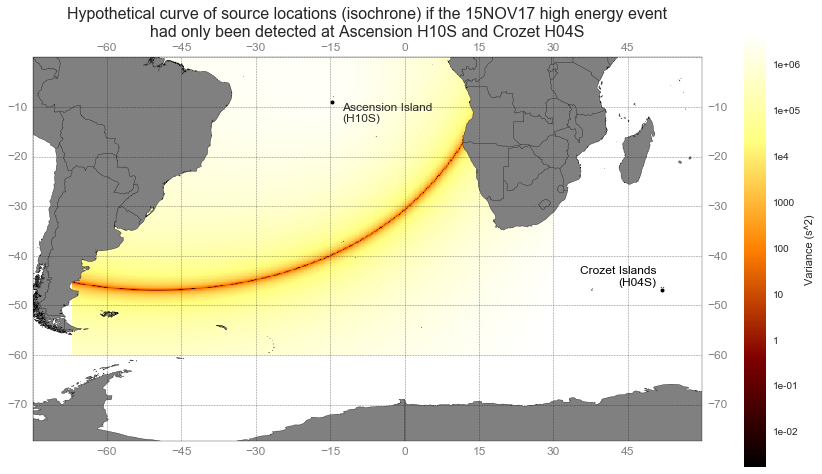

In [34]:
fig = plt.figure(figsize = (15,10))
ax_extent = (-75,60,-60,0)
ax = plot_grid(std[0]**2, data_extent, ax_extent, fig, projection,
              vmin = None, vmax = None, label = 'Variance (s^2)')
plt.title(('Hypothetical curve of source locations (isochrone) if the 15NOV17 high energy event\n' +
           'had only been detected at Ascension H10S and Crozet H04S'), y = 1.04, fontsize = 16)

plt.plot(ascension_s[0],ascension_s[1],
         color = 'black', marker = 'o', markersize = 4)
plt.text(ascension_s[0] + 2, ascension_s[1] - 4, 'Ascension Island\n(H10S)',
         horizontalalignment='left', fontsize = 12)
plt.plot(crozet_s[0],crozet_s[1],
         color = 'black', marker = 'o', markersize = 4)
plt.text(crozet_s[0] - 1, crozet_s[1] + 1, 'Crozet Islands\n(H04S)',
         horizontalalignment='right', fontsize = 12, color = 'black');

### For each sensor, an estimated source time was calculated at each cell using the arrival time and the sound speed grid data. The darker the cell color, the more closely the source times match indicating that the source was more likely to have been located in that cell. For the lighter colored cells, source times don't match as well (higher variance), so the source is less likely to have been there. Cells with close to zero variance (black) aren't necessarily the correct answer. Uncertainties in arrival time, sound speed, and horizontal acoustic path deflection must be considered as well. 

### For a given cell, if the source times differ by more than 10 seconds (standard deviation of 5 seconds for two sensors, or variance of 25 s^2) let's assume for now that the cell isn't a potential source location. Most of the uncertainty in this analysis is probably due to the lack of an obvious peak arrival time at the Crozet Islands H04S sensor, followed by horizontal path deviations from strong sound speed gradients in the antarctic. We will incorporate uncertainty more fully later on.

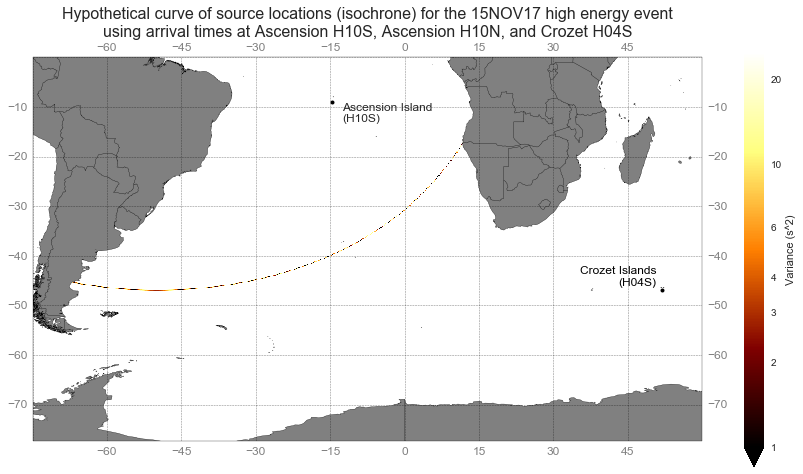

In [35]:
fig = plt.figure(figsize = (15,10))
ax_extent = (-75,60,-60,0)
ax = plot_grid(std[0]**2, data_extent, ax_extent, fig, projection,
              vmin = 1**2, vmax = 5**2, label = 'Variance (s^2)')
plt.title(('Hypothetical curve of source locations (isochrone) for the 15NOV17 high energy event\n' +
           'using arrival times at Ascension H10S, Ascension H10N, and Crozet H04S'), y = 1.04,
          fontsize = 16)

plt.plot(ascension_s[0],ascension_s[1],
         color = 'black', marker = 'o', markersize = 4)
plt.text(ascension_s[0] + 2, ascension_s[1] - 4, 'Ascension Island\n(H10S)',
         horizontalalignment='left', fontsize = 12)
plt.plot(crozet_s[0],crozet_s[1],
         color = 'black', marker = 'o', markersize = 4)
plt.text(crozet_s[0] - 1, crozet_s[1] + 1, 'Crozet Islands\n(H04S)',
         horizontalalignment='right', fontsize = 12, color = 'black');

### Because the hydrophone triplet on the northern side of Ascension Island also detected the explosion, a lot of the isochrone line can be eliminated as a potential source location. Using that data results in two possible source locations, one of which will be ruled out next.

In [36]:
# 100 by 100 grid takes about 3 seconds (per sensor) to compute on a 2013 Macbook Pro
# 400 by 400 grid should take about 16 * 3 seconds per sensor
mean, std = (None, None)
grid_shape = (400, 400)
data_extent = (-67,30,-60,0)
start = time.clock()
mean, std = find_source(sensor_info, data_extent, grid_shape, dsca_speed)
print('That took', np.round(time.clock() - start,1), 'seconds to compute.')

That took 132.9 seconds to compute.


Western ellipse:
Average Time: 13:51:17 UTC
Eastern ellipse:
Average Time: 14:23:49 UTC


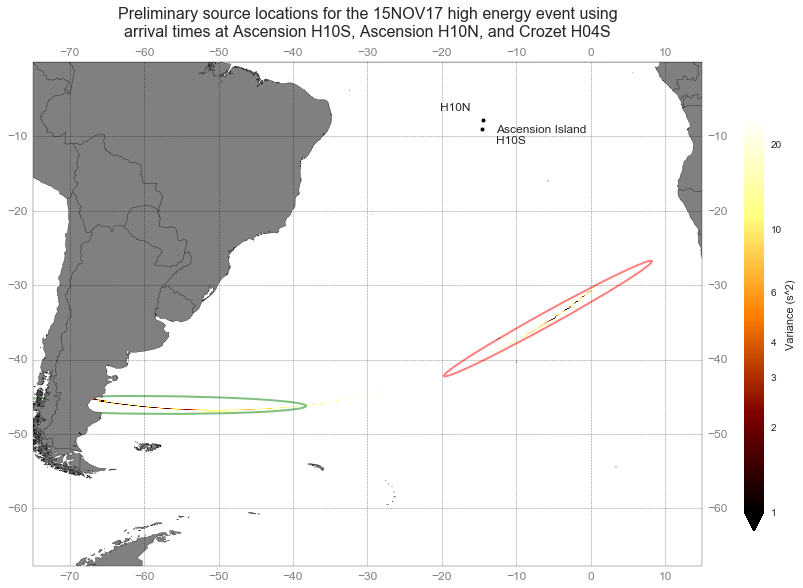

In [38]:
fig = plt.figure(figsize = (15,10))
ax_extent = (-75,15,-60,0)
ax = plot_grid(std[0]**2, data_extent, ax_extent, fig, projection,
              vmin = 1**2, vmax = 5**2, label = 'Variance (s^2)')
plt.title(('Preliminary source locations for the 15NOV17 high energy event using\n' +
           'arrival times at Ascension H10S, Ascension H10N, and Crozet H04S'), y = 1.04,
          fontsize = 16)

data_ext1 = [data_extent[0],
             (data_extent[1] - data_extent[0])*175/400 + data_extent[0],
             data_extent[2], data_extent[3]]
data_ext2 = [data_extent[1] - (data_extent[1] - data_extent[0])*225/400,
             data_extent[1], data_extent[2], data_extent[3]]

mass_level = 0.95
std_cutoff = 6
el_data1 = source_grid_to_ellipse(data_ext1, mean[:,:,:175],
                                  std[:,:,:175], std_cutoff = std_cutoff,
                                  mass_level = mass_level)
el1 = Ellipse(el_data1['mean'], el_data1['semi_major'] * 2,
              el_data1['semi_minor'] * 2, el_data1['ccw_from_x-axis'],
              linewidth = 2, facecolor = 'None', edgecolor = 'green',
              alpha = 0.5)
el_data2 = source_grid_to_ellipse(data_ext2, mean[:,:,175:],
                                  std[:,:,175:], std_cutoff = std_cutoff,
                                  mass_level = mass_level)
el2 = Ellipse(el_data2['mean'], el_data2['semi_major'] * 2,
              el_data2['semi_minor'] * 2, el_data2['ccw_from_x-axis'],
              linewidth = 2, facecolor = 'None', edgecolor = 'red',
              alpha = 0.5)
ax.add_patch(el1)
ax.add_patch(el2)

plt.plot(ascension_s[0],ascension_s[1],
         color = 'black', marker = 'o', markersize = 4)
plt.text(ascension_s[0] + 2, ascension_s[1] - 2, 'Ascension Island\nH10S',
         horizontalalignment='left', fontsize = 12)
plt.plot(ascension_n[0],ascension_n[1],
         color = 'black', marker = 'o', markersize = 4)
plt.text(ascension_s[0] - 1.5, ascension_s[1] + 2.5, 'H10N',
         horizontalalignment='right', fontsize = 12);
print('Western ellipse:\nAverage Time:',
      el_data1['avg_time'].strftime('%H:%M:%S'), 'UTC')
print('Eastern ellipse:\nAverage Time:',
      el_data2['avg_time'].strftime('%H:%M:%S'), 'UTC')

### So how do we determine which of the two locations is the right one?

### CTBTO can use differences in signal phase across each of the hydrophones in a triplet to derive a bearing (azimuth) for each energy peak. The second plot from the top in this image shows the bearings measured from H10N. The first three energy peaks are indicated at the bottom, as well as another one detected much later at 15:13 UTC labeled "South Georgia reflection." 
![H10N_bearing_calculations](graficos-reporte-ara-san-juan-3.jpg)

### The colors correspond to the scale on the righthand side to indicate the bearings. The "main arrival" is from approximately 218 degrees (light blue) and the bearings increase slightly for the next two energy peaks. The bearing from the peak at 15:13 UTC is much lower than the previous ones.
### This image also released by CTBTO shows the bearings on a globe.
![CTBTO_measured_bearings](graficos-reporte-ara-san-juan-2.jpg)

### The fact that the bearings are not all the same indicates that the energy peaks following the initial explosion are either unrelated to eachother (seems very unlikely) or they are just reflections off of the continental slope. The three main peaks cannot be from subseqeunt explosions onboard the missing submarine unless it was travelling at an impossible rate of speed.  

### So, without the raw signal phase information is there anything we can do to verify CTBTO's bearing calculations in a somewhat independent manner? Yes.

### The northern and southern hydrophone triplets at Ascension Island can be thought of as a 2 hydrophone linear array with 122.62 km separation between them. The time delay between the signal arriving at the southern and northern hydrophones can be used to calulate bearings relative to the axis between H10N and H10S, bearing 188 (roughly north/south). If the sound had arrived at each triplet at the exact same time, then the sound would be approaching either from bearing 098 or 278 (due roughly east/west). Since we know that the initial energy peak arrived at H10N 71 seconds after it arrived at H10S, we can determine two possible arrival bearings, one on the left, and another on the right, but we won't know for sure which is the correct one immediately. 

In [39]:
#Find the half-way point between H10N and H10S
H10_geodesic_data = geodesic_data(ascension_n, ascension_s, num = 13)
H10_center = H10_geodesic_data['coords'][6]
# Find the average sound speed between between H10N and H10S
H10_mean_speed = np.mean(dsca_speed[coords_to_index(H10_geodesic_data['coords'])])

In [40]:
time_delays = []
for i in range(3):
    time_delays.append((arrival_times['H10N'][i] -
                        arrival_times['H10S'][i]).total_seconds())
time_delays

[71.095096, 68.54567, 66.819339]

In [41]:
# Use time delays to calculate arrival bearings
H10_axis = np.asscalar(H10_geodesic_data['brg_final'] + H10_geodesic_data['brg_initial']) / 2
brgs = []
for time_delay in time_delays:
    alpha = np.degrees(np.arccos(time_delay/(np.asscalar(H10_geodesic_data['dist'])/H10_mean_speed)))
    brgs.append(((H10_axis + alpha) % 360, (H10_axis - alpha) % 360))
brgs

[(219.47103593477999, 157.8868739168899),
 (222.76198455101033, 154.59592530065956),
 (224.8394466267583, 152.51846322491159)]

In [42]:
coord_arr_r = []
coord_arr_l = []
dist_arr = np.linspace(0, 7 * 10**6, 20)
for brg_r, brg_l in brgs:
    coord_arr_r.append(np.asarray(geodesic.direct(H10_center,brg_r,dist_arr)))
    coord_arr_l.append(np.asarray(geodesic.direct(H10_center,brg_l,dist_arr)))

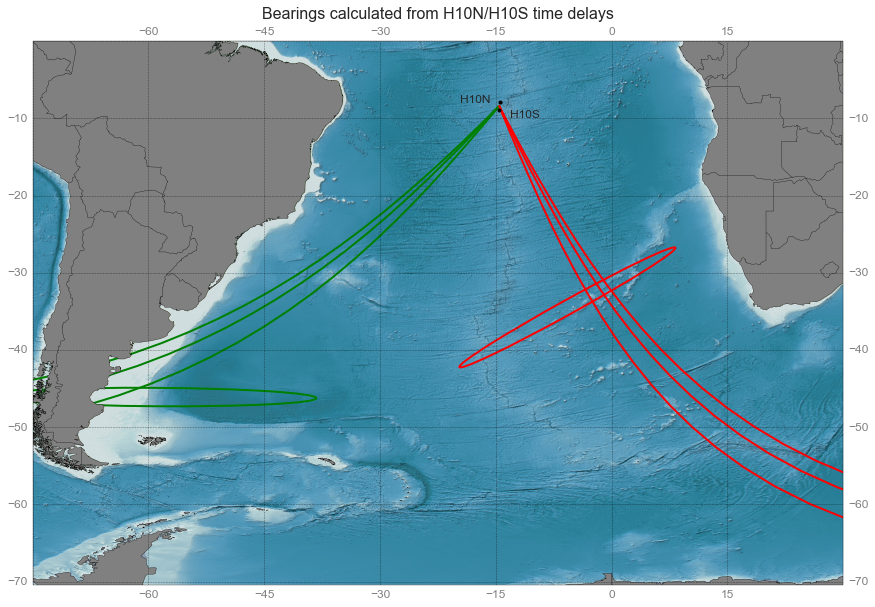

In [43]:
fig = plt.figure(figsize = (15,10))
ax_extent = (-75,30,-60,0)
#ax = plot_results(std, data_extent, ax_extent, fig, projection, std_limit = [0.5,10])
ax = plot_grid(None, None, ax_extent, fig, projection)

plt.title(('Bearings calculated from H10N/H10S time delays'),
          y = 1.03, fontsize = 16)

ax.add_wms('https://gis.ngdc.noaa.gov/arcgis/services/web_mercator/gebco_2014_hillshade/MapServer/WMSServer?',
           '0')
plt.plot(ascension_s[0],ascension_s[1],
         color = 'black', marker = 'o', markersize = 4, zorder = 1000)
plt.text(ascension_s[0] + 1.5, ascension_s[1] - 1, 'H10S',
         horizontalalignment='left', fontsize = 12)
plt.plot(ascension_n[0],ascension_n[1],
         color = 'black', marker = 'o', markersize = 4, zorder = 1000)
plt.text(ascension_s[0] + -1, ascension_s[1] + 1, 'H10N',
         horizontalalignment='right', fontsize = 12)

for i, (brg_right, brg_left) in enumerate(zip(coord_arr_r,coord_arr_l)):
    plt.plot(brg_right[:,0],brg_right[:,1],
             color = 'green', linewidth = 2,
             transform = ccrs.Geodetic(), zorder = 1)

    plt.plot(brg_left[:,0],brg_left[:,1],
             color = 'red', linewidth = 2,
             transform = ccrs.Geodetic(), zorder = 1)

el1 = Ellipse(el_data1['mean'], el_data1['semi_major'] * 2,
              el_data1['semi_minor'] * 2, el_data1['ccw_from_x-axis'],
              linewidth = 2, facecolor = 'None', edgecolor = 'green')
el2 = Ellipse(el_data2['mean'], el_data2['semi_major'] * 2,
              el_data2['semi_minor'] * 2, el_data2['ccw_from_x-axis'],
              linewidth = 2, facecolor = 'None', edgecolor = 'red')
ax.add_patch(el1)
ax.add_patch(el2);

### Note that the bearing accuracy isn't really as perfect as the plot makes them out to be since the measured time delays aren't exact. Also, the bearings are plotted as simple geodesic curves, ignoring horizontal deflection from sound speed gradients. 

### The important thing to observe is that the second bearing is a bit further north, and the third is even further still, matching CTBTO's work closely.  

### Checking the bearing to the 15:11 UTC signal isn't possible since I don't have an image of its arrival at the H10S and H10N sensors, but at this point I'm satisfied that my results coincide with CTBTO's reasonably. The eastern, red ellipse should be ruled out as the source and we are ready for further analysis in the region of the green, western ellipse.

# Uncertainty
### Uncertainty in this model is due to errors in measurement of the peak arrival time, the sound speed data, and the distance traveled due to horizontal ray path deflection. 

## Statistical models for uncertainty estimation:
### Arrival Time: 
### Let's assume arrival time measurement error is normally distributed with a zero mean. Standard deviation will be determined by looking at the shape of the peak. Crozet (H04S) has a broad peak, whereas Ascension (H10N/S) saw a very sharp and defined peak.

### Sound Speed: 
### For now let's assume a normal distribution with zero mean and 1 m/s standard deviation. That's surely too simple a model. 
### Another method would be to look at the difference in sound speed between the current month and the previous and following months for every path being evaluated (slow to do?). I looked at DSCA sound speed along the paths from Crozet and Ascension to the last known position of ARA San Juan and compared previous and following month mean sound speeds. Standard deviations were 0.63 m/s and 0.14 m/s, respectively. I feel like that is low for many reasons, especially since the oceans have surely changed some since 2009 when this data set was compiled and the data, while good, probably isn't quite that good. 1 m/s uncertainty should suffice for now. 

### Distance: 
### By default, the model assumes that sound moves along perfectly straight geodesic paths, but that isn't exactly correct. Sound bends horizontally and more deviation should be expected near the north and south poles due to the larger temperature gradients and the effect of sound tending to bend away from higher latitudes. We need a positive only distribution since sound will never take a shorter path than the geodesic, assuming it only travels within the SOFAR channel. So, for lack of a better idea, we will model uncertainty in path length using an exponential distribution. As a quick and dirty approximation to account for differences in path deflection, the distribution will be multiplied by the standard deviation of sound speeds along each given acoustic path. In effect, we will be assuming that variations in the speed of sound at the deep sound channel axis are correlated with horizontal sound speed gradients. I'm not exactly sure how true this is, but it seems like a fair approximation for now and should be better than using the same distribution shape for every acoustic path.

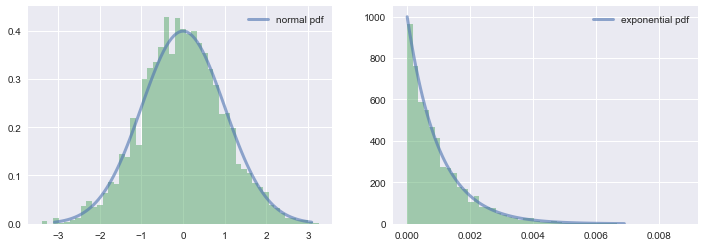

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12,4)
rv_norm = norm(scale = 1)
x = np.linspace(rv_norm.ppf(0.001), rv_norm.ppf(0.999), 100)
ax1.plot(x, rv_norm.pdf(x),'-', lw=3, alpha=0.6, label='normal pdf')
ax1.hist(rv_norm.rvs(size=4000), normed=True, histtype='stepfilled', 
         bins = 50, alpha=0.5);
ax1.legend(loc='best', frameon=False)

rv_exp = expon(scale = 0.001)
x = np.linspace(rv_exp.ppf(0.001), rv_exp.ppf(0.999), 100)
ax2.plot(x, rv_exp.pdf(x),'-', lw=3, alpha=0.6, label='exponential pdf')
ax2.hist(rv_exp.rvs(size=4000), normed=True, histtype='stepfilled', 
         bins = 50, alpha=0.5);
ax2.legend(loc='best', frameon=False);

In [45]:
# Assume arrival peak time is normally distrubuted (gaussian).
# The scale parameter (standard deviation) gets added later for each 
#  hydroacoustic station based on an estimate from eyeballing the CTBTO image.
t_model = norm(loc = 0)

# Assume sound speed is normally distributed.
s_model = norm(loc = 0, scale = 2)

# Assume deviation from the geodesic path is exponentially distributed.
d_model = expon(loc = 0, scale = 0.02)
#d_model = None

mean, std = (None, None)

In [46]:
data_extent = (-67,-40,-55,-37)
#data_extent = (-67,-45,-50,-43)

grid_shape = (100, 100)
start = time.clock()
n_samples = 4000
mean, std = find_source(sensor_info, data_extent, grid_shape, dsca_speed,
                        t_model = t_model, d_model = None,
                        s_model = s_model, n_samples = n_samples)
print('That took', np.round(time.clock() - start,1), 'seconds to compute.') 
print('Results:')
print('Minimum std dev is %s' % np.round(std.min(),2), 'seconds.')
print('0.1 percentile std dev is %s' % np.round(np.percentile(std, 0.1),2), 'seconds.')

That took 29.9 seconds to compute.
Results:
Minimum std dev is 0.01 seconds.
0.1 percentile std dev is 1.15 seconds.


Source time: 13:49:15 UTC
95% Confidence interval ellipse:
  Latitude:  -45.9843
  Longitude: -62.0557
  Semi-major: 1260.78 km
  Semi-minor: 54.99 km
  Strike Axis: 273.59 degrees


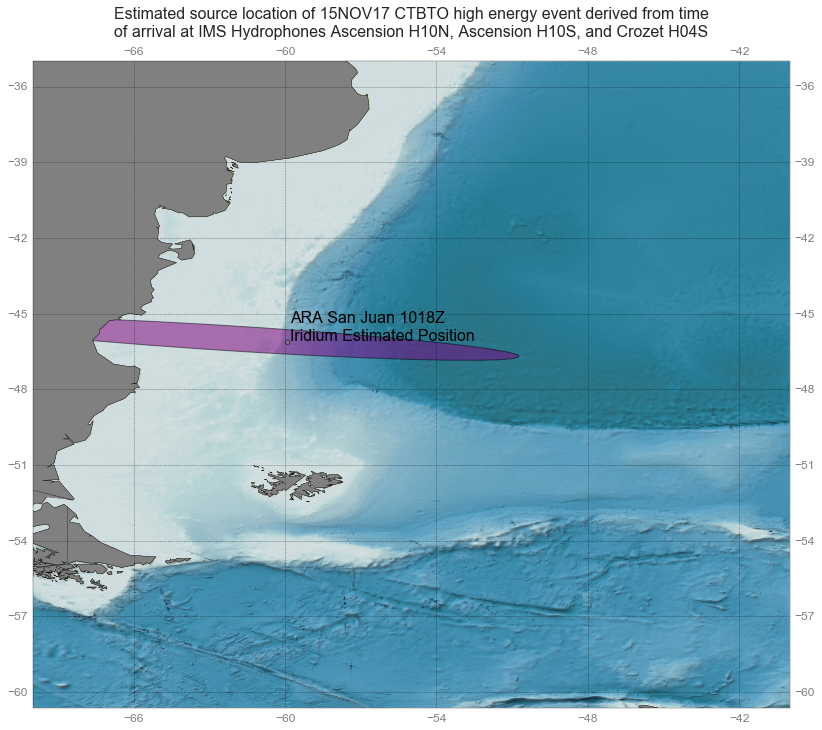

In [47]:
projection=ccrs.PlateCarree()
fig = plt.figure(figsize = (15,10))
ax_extent = (-70,-40,-60,-35)
ax = plot_grid(None, None, ax_extent, fig, projection, grid_lines = None)
'''ax = plot_grid(1/(1/std**2).mean(axis = 0), data_extent, ax_extent, fig,
               projection, vmax = 15**2, label = 'Variance (s^s)')'''
ax.set_extent(ax_extent)
ax.add_wms('https://gis.ngdc.noaa.gov/arcgis/services/web_mercator/gebco_2014_hillshade/MapServer/WMSServer?',
           '0')

ax.add_feature(land_feature_hi, facecolor='grey', edgecolor='black');
ax.add_feature(border_feature_hi, edgecolor='black', facecolor = 'grey');

plt.title(('Estimated source location of 15NOV17 CTBTO high energy event derived from time\n' +
           'of arrival at IMS Hydrophones Ascension H10N, Ascension H10S, and Crozet H04S'), y = 1.03,
          fontsize = 16)

'''plt.plot(iridium['coord'][0],iridium['coord'][1],
         color = 'black', marker = 'o', markersize = 5)'''
plt.text(iridium['coord'][0] + 0.1, iridium['coord'][1] + 0.1, 'ARA San Juan 1018Z\nIridium Estimated Position',
         horizontalalignment='left', fontsize = 16, color = 'black');

mass_level = 0.95
el_data = source_grid_to_ellipse(data_extent, mean, std,
                                 std_cutoff = 30, mass_level = mass_level)
el = Ellipse(el_data['mean'],el_data['semi_major'] * 2,
             el_data['semi_minor'] * 2, el_data['ccw_from_x-axis'],
             linewidth = 1, facecolor = 'purple', edgecolor = 'black',
             alpha = 0.5)
ax.add_patch(el)
# convert km to approximate degrees lat/lon
ir_diameter = iridium['radius_km']/1.852/60*2
ir_el = Ellipse(iridium['coord'],ir_diameter,ir_diameter,0,
                linewidth = 1, facecolor = 'grey', edgecolor = 'black',
                alpha = 0.5, zorder = 10, transform = projection)
ax.add_patch(ir_el)
print('Source time:',el_data['avg_time'].strftime('%H:%M:%S'),'UTC')
print('{0}% Confidence interval ellipse:'.format((int(mass_level*100))))
print('  Latitude: ',np.round(el_data['mean'][1],4))
print('  Longitude:',np.round(el_data['mean'][0],4))
print('  Semi-major:', np.round(1.852 * 60 * el_data['semi_major'],2), 'km')
print('  Semi-minor:', np.round(1.852 * 60 * el_data['semi_minor'],2), 'km')
print('  Strike Axis:', np.round(el_data['strike'] ,2), 'degrees')
fig.facecolor = 'white'
fig.tight_layout()
#plt.savefig('Event_large_no_contours.png')


## Ways to improve this model: 
### 1. A ray tracing program or acoustic mode propagation model could be used to compute eigenrays, the possible ray paths from a point to a receiver, accounting for horizontal deflection due to sound speed gradients. The eigenrays would give us a better travel distance and a more accurate sound path from which to determine average sound speed. 
### 2. Fit a model to any existing data sets containing information about how sound refracts away from the north and south pole and use that to determine path lengths. Unless there has been new research in this area, my understanding is that the physics of this phenomenon aren't yet understood well enough to produce a theoretical model.
### 3. Currently, I only know a single location for each hydrophone triplet. If the locations of each hydrophone in each triplet were to become available, and arrival time information at sufficiently fine resolution for each hydrophone were also made available, then my source geolocation might be improved by determining a bearing from each triplet. The model, as is, could easily be adjusted to incorporate this information but more work would need to be done to incorporate varying levels of measurement uncertainty between each triplet at a hydroacoustic station, or between each hydrophone in a triplet. Without incorporating this uncertainty, there could be erroneously small geolocation ellipses or the measurement errors might prevent a satisfactory geolocation from being generated.

In [48]:
# Measurements taken from screen captures released by CTBTO
#  analyzed in Keynote (Mac PowerPoint) to estimate peak
#  arrival times and std. dev. of peak times
'''
H10N
14:55:00 start time
621 pts is 0.18 hrs
244 pts to first peak, s.d. is 2 pts
328 pts to second peak, s.d. is 3 pts
380 pts to third peak, s.d. is 3 pts
H10S
14:55:00 start time
625 pts is 0.18 hrs
177 pts to first peak, s.d. is 2 pts
264 pts to second peak, s.d. is 3 pts
318 pts to third peak, s.d. is 3 pts
H04S
15:11:00 start time
625 pts is 0.18 hrs
499 pts to the first peak, s.d. is 5 pts
''';

In [49]:
def peak_time(peak_pts, start_time, pts_per_hr, sd_pts):
    peak_time = start_time + timedelta(0, peak_pts / pts_per_hr * 3600)
    sd = timedelta(0, sd_pts / pts_per_hr * 3600)
    return (peak_time, sd)

In [50]:
# H10N
start_time = datetime(2017,11,15,14,55,0)
pts_per_hr = 621/0.18

for pts, s in zip([244, 328, 380], [2,3,3]):
    print(peak_time(pts, start_time, pts_per_hr, s))

(datetime.datetime(2017, 11, 15, 14, 59, 14, 608696), datetime.timedelta(0, 2, 86957))
(datetime.datetime(2017, 11, 15, 15, 0, 42, 260870), datetime.timedelta(0, 3, 130435))
(datetime.datetime(2017, 11, 15, 15, 1, 36, 521739), datetime.timedelta(0, 3, 130435))


In [51]:
# H10S
start_time = datetime(2017,11,15,14,55,0)
pts_per_hr = 625/0.18

for pts, s in zip([177, 264, 318], [2,3,3]):
    print(peak_time(pts, start_time, pts_per_hr, s))

(datetime.datetime(2017, 11, 15, 14, 58, 3, 513600), datetime.timedelta(0, 2, 73600))
(datetime.datetime(2017, 11, 15, 14, 59, 33, 715200), datetime.timedelta(0, 3, 110400))
(datetime.datetime(2017, 11, 15, 15, 0, 29, 702400), datetime.timedelta(0, 3, 110400))


In [52]:
# H04S
start_time = datetime(2017,11,15,15,11,0)
pts_per_hr = 625/0.18

for pts, s in zip([499], [5]):
    print(peak_time(pts, start_time, pts_per_hr, s))

(datetime.datetime(2017, 11, 15, 15, 19, 37, 363200), datetime.timedelta(0, 5, 184000))


In [53]:
ara_san_juan_data = {
    'arrival_times':{
        'H04S': [datetime(2017, 11, 15, 15, 19, 37, 363200)],
        'H10N': [datetime(2017, 11, 15, 14, 59, 14, 608696),
                 datetime(2017, 11, 15, 15, 0, 42, 260870),
                 datetime(2017, 11, 15, 15, 1, 36, 521739)],
        'H10S': [datetime(2017, 11, 15, 14, 58, 3, 513600),
                 datetime(2017, 11, 15, 14, 59, 33, 715200),
                 datetime(2017, 11, 15, 15, 0, 29, 702400)]},
    'arrival_time_sd':{
        'H04': [timedelta(0, 5, 184000)],
        'H10': [timedelta(0, 2, 86957),
                timedelta(0, 3, 130435),
                timedelta(0, 3, 130435)]},
    'ims_locs': {
        'H10N': (-14.48, -7.845),
        'H10S': (-14.648, -8.941),
        'H04S': (51.8, -46.883)},
    'sub_locs': {
        'iridium': {
            'coord': (-59.9, -46.1333),
            'radius_km': 10,
            'time': datetime(2017, 11, 15, 10, 30)},
        'self_reported': {
            'coord': (-60.1333, -46.7333),
            'time': datetime(2017, 11, 15, 3, 30)}}}

In [54]:
np.save('ARA_San_Juan_data.npy',ara_san_juan_data)